# Import

In [2]:
import json
import re
import ast
from tqdm import tqdm
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Data

In [3]:
# Charger les données traitées pour inspection
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Afficher un exemple
example_idx = 0  # Modifier cet indice pour voir d'autres exemples
example = processed_data[example_idx]

# Afficher avec une mise en forme claire
print("=== Exemple traité ===")
print("Tokenized Text:")
print(example['tokenized_text'])
print("\nNER Spans:")
for span in example['ner']:
    print(f" - Start: {span[0]}, End: {span[1]}, Entity Type: {span[2]}")
print("\nNegative Entities:")
print(example['negative'])

=== Exemple traité ===
Tokenized Text:
['Q', ':', 'Position', 'character', 'based', 'on', 'enemy', 'coordinates', 'in', 'lua', 'I', 'have', 'written', 'a', 'function', 'here', 'which', 'should', 'turn', 'my', 'character', 'based', 'on', 'enemy', 'coordinates', 'but', 'it', "'", 's', 'not', 'perfect', 'because', 'it', 'does', 'not', 'always', 'turn', 'where', 'I', 'want', 'it', 'to', 'and', 'perhaps', 'there', 'is', 'a', 'better', 'way', 'of', 'writing', 'it', 'local', 'myPosition', '=', '{', 'x', '=', '350', ',', 'y', '=', '355', '}', 'local', 'enemyPosition', '=', '{', 'x', '=', '352', ',', 'y', '=', '354', '}', 'local', 'xValue', ',', 'yValue', ',', 'xDir', ',', 'yDir', ',', 'dir', 'if', 'myPosition', '.', 'x', '>', 'enemyPosition', '.', 'x', 'then', 'xValue', '=', 'myPosition', '.', 'x', '-', 'enemyPosition', '.', 'x', 'elseif', 'myPosition', '.', 'x', '<', 'enemyPosition', '.', 'x', 'then', 'xValue', '=', 'myPosition', '.', 'x', '-', 'enemyPosition', '.', 'x', 'else', 'xValue', '='

In [4]:
model = GLiNER(pretrained_model_name="microsoft/deberta-v3-base", span_max_length=2, hidden_size=768)
# Initialiser le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\doria\anaconda3\envs\vincentorch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\doria\anaconda3\envs\vincentorch\Lib\site-packages\transformers\convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


GLiNER(
  (encoder): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropou

In [5]:
from transformers import AutoTokenizer
import torch
from tqdm import tqdm
import json

def prepare_data_for_training(processed_data, model, max_length=512):
    input_ids, labels, entity_tensors, attention_masks = [], [], [], []

    # Créer un mapping des types d'entités vers des entiers
    entity_types = {entity for entry in processed_data for _, _, entity in entry["ner"]}
    # Ajouter chaque type d'entité comme un token spécial dans le tokenizer
    special_tokens = [f"[ENT] {entity}" for entity in entity_types]
    model.tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
    model.encoder.resize_token_embeddings(len(model.tokenizer))

    for entry in tqdm(processed_data, desc="Processing Data", unit="entry"):
        tokenized_text = entry["tokenized_text"]
        ner_spans = entry["ner"]
                
        # Générer le tensor de labels
        label_tensor = torch.zeros(max_length, dtype=torch.long)
        
        # Collecter les entités uniques pour l'entrée actuelle
        current_entity_id = []
        current_entity_str = []
        
        for start, end, entity_type in ner_spans:
            if start < max_length and end < max_length:
                entity_token_id = model.tokenizer.convert_tokens_to_ids(f'[ENT] {entity_type}')

                label_tensor[start:end + 1] = entity_token_id
                
                if entity_token_id not in current_entity_id:
                    current_entity_id.append(entity_token_id)  # Ajouter le nombre de tokens
                
                if entity_type not in current_entity_str:
                    current_entity_str.append(entity_type)  # Ajouter le type d'entité en clair

        # Ajouter les entités comme préfixe à la séquence
        entity_tokens = " ".join(f"[ENT] {et}" for et in current_entity_str)
        
        # Tokenizer la séquence complète
        encoded = model.tokenizer(
            tokenized_text, return_tensors="pt", padding="max_length", truncation=True,is_split_into_words=True, add_special_tokens=False
        )

        # Récupération des IDs des mots (chaque sous-token est associé à un mot original)
        word_ids = encoded.word_ids()

        # Filtrage pour ne conserver que les IDs des premiers sous-tokens de chaque mot
        first_subtoken_ids = [
            encoded["input_ids"][0, i].item() for i, word_id in enumerate(word_ids) if word_id is not None and (i == 0 or word_ids[i - 1] != word_id)
        ]

        encoded_entity = model.tokenizer(
            entity_tokens, return_tensors="pt", padding="max_length", truncation=True,is_split_into_words=False, add_special_tokens=False
        )

        if(len(current_entity_str) != len(encoded_entity["input_ids"][0]) or 
           len(tokenized_text) != len(first_subtoken_ids)) :
            print("error, not same size")
            continue
        
        sep_id = model.tokenizer.convert_tokens_to_ids(f'[SEP]')

        combined_ids = (
            encoded_entity["input_ids"][0].tolist() +  # Convertir en liste
            [sep_id] +  # Ajouter le token [SEP]
            first_subtoken_ids  # Ajouter les premiers sous-tokens
        )

        if(len(combined_ids) != (len(encoded_entity["input_ids"][0]) + len(first_subtoken_ids) + 1)):
            print("error, not same size")
            continue


        # S'assurer que toutes les séquences sont de la même taille
        combined_ids = combined_ids[:max_length]  # Tronquer si nécessaire
        combined_ids += [0] * (max_length - len(combined_ids))  # Ajouter du padding si nécessaire

        # Créer l'attention mask
        attention_mask = [1] * len(combined_ids) + [0] * (max_length - len(combined_ids))

        # Convertir les entités en un tensor
        entity_tensor = torch.tensor(current_entity_id, dtype=torch.long)
        
        # Ajouter les données tokenisées, les labels et les attention masks
        input_ids.append(torch.tensor(combined_ids, dtype=torch.long))
        labels.append(label_tensor)
        entity_tensors.append(entity_tensor)
        attention_masks.append(torch.tensor(attention_mask, dtype=torch.long))

    return torch.stack(input_ids), torch.stack(labels), entity_tensors, torch.stack(attention_masks)


# Charger les données générées précédemment
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Préparer les données avec suivi d'avancement
input_ids, labels, entity_tensors, attention_masks = prepare_data_for_training(processed_data, model)

Processing Data:   0%|          | 0/45889 [00:00<?, ?entry/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Processing Data:  10%|▉         | 4388/45889 [00:14<02:11, 315.66entry/s]

error, not same size


Processing Data:  34%|███▍      | 15513/45889 [00:51<01:33, 324.96entry/s]

error, not same size


Processing Data:  38%|███▊      | 17454/45889 [00:57<01:29, 317.02entry/s]

error, not same size


Processing Data:  53%|█████▎    | 24213/45889 [01:19<01:11, 303.56entry/s]

error, not same size


Processing Data:  64%|██████▍   | 29373/45889 [01:36<00:51, 322.03entry/s]

error, not same size


Processing Data:  73%|███████▎  | 33394/45889 [01:49<00:39, 312.62entry/s]

error, not same size


Processing Data:  76%|███████▌  | 34905/45889 [01:54<00:35, 312.34entry/s]

error, not same size


Processing Data:  88%|████████▊ | 40338/45889 [02:12<00:17, 324.67entry/s]

error, not same size


Processing Data: 100%|██████████| 45889/45889 [02:30<00:00, 305.74entry/s]


In [6]:
print(len(model.tokenizer))
print(len(input_ids))
print(len(entity_tensors))

143177
45881
45881


In [7]:
# Afficher les formes des tensors principaux
print(f"Forme de input_ids : {input_ids.shape}")
print(f"Forme de attention_masks : {attention_masks.shape}")
print(f"Forme de labels : {labels.shape}")

# Afficher un exemple pour les tensors principaux
print("\nExemple de input_ids (première entrée) :")
print(input_ids[0])

print("\nExemple de attention_masks (première entrée) :")
print(attention_masks[0])

print("\nExemple de labels (première entrée) :")
print(labels[0])

# Afficher un exemple pour les entity_tensors
print("\nExemple de entity_tensors (première entrée) :")
print(entity_tensors[0])

Forme de input_ids : torch.Size([45881, 512])
Forme de attention_masks : torch.Size([45881, 512])
Forme de labels : torch.Size([45881, 512])

Exemple de input_ids (première entrée) :
tensor([133419, 132993, 138831,      2,   1729,    877,  18172,   1470,    636,
           277,   4648,  14321,    267,  96792,    273,    286,   1223,    266,
          1571,    422,    319,    403,    930,    312,   1470,    636,    277,
          4648,  14321,    304,    278,    382,   1550,    298,    801,    401,
           278,    490,    298,    489,    930,    399,    273,    409,    278,
           264,    263,   1733,    343,    269,    266,    493,    384,    265,
           898,    278,    588,    312,   1842,  13856,   1204,   1842,   7351,
           366,   2982,   1842,  40059,  15805,    588,   4648,   1842,  13856,
          1204,   1842,  42091,    366,   2982,   1842,  50238,  15805,    588,
          1204,    366,   2982,    366,   1204,    366,   2982,    366,  30791,
           337,  

# Dataset and Dataloader

In [8]:
proportion = 1

In [9]:
from torch.utils.data import DataLoader, Dataset, random_split
import torch

class NERDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels, entities, max_span_length=2):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels  # Liste des labels pour chaque token
        self.entities = entities  # Liste des entités uniques
        self.max_span_length = max_span_length

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        input_id = self.input_ids[idx]
        attention_mask = self.attention_masks[idx]
        token_labels = self.labels[idx]  # Labels token-par-token
        entity_ids = self.entities[idx]  # Entités pour cet exemple

        num_tokens = len(input_id) - len(entity_ids) - 1
        spans = [
            (start, end)
            for start in range(num_tokens)
            for end in range(start, min(start + self.max_span_length, num_tokens))
        ]
        num_spans = len(spans)
        num_entities = len(entity_ids)

        # Matrice binaire : spans x entities
        binary_labels = torch.zeros(num_spans, num_entities, dtype=torch.float)

        for span_idx, (start, end) in enumerate(spans):
            span_labels = token_labels[start:end + 1]
            for entity_idx, entity_id in enumerate(entity_ids):
                if all(label == entity_id for label in span_labels):
                    binary_labels[span_idx, entity_idx] = 1

        return input_id, attention_mask, spans, entity_ids, binary_labels


In [10]:
ind = int(len(input_ids) * proportion)

In [11]:
# Créer le dataset
dataset = NERDataset(input_ids[:ind], attention_masks[:ind], labels[:ind], entity_tensors[:ind])

# Exemple de récupération d'une entrée
input_id, attention_mask, spans, entity_ids, binary_labels = dataset[0]

print("Input ID:", input_id)
print("Spans:", spans)
print("Entity IDs:", entity_ids)
print("Binary Labels:", binary_labels)

Input ID: tensor([133419, 132993, 138831,      2,   1729,    877,  18172,   1470,    636,
           277,   4648,  14321,    267,  96792,    273,    286,   1223,    266,
          1571,    422,    319,    403,    930,    312,   1470,    636,    277,
          4648,  14321,    304,    278,    382,   1550,    298,    801,    401,
           278,    490,    298,    489,    930,    399,    273,    409,    278,
           264,    263,   1733,    343,    269,    266,    493,    384,    265,
           898,    278,    588,    312,   1842,  13856,   1204,   1842,   7351,
           366,   2982,   1842,  40059,  15805,    588,   4648,   1842,  13856,
          1204,   1842,  42091,    366,   2982,   1842,  50238,  15805,    588,
          1204,    366,   2982,    366,   1204,    366,   2982,    366,  30791,
           337,    312,    323,   1204,   2108,   4648,    323,   1204,    393,
          1204,   1842,    312,    323,   1204,    341,   4648,    323,   1204,
           995,    312,    323

In [12]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids, attention_masks, spans, entity_ids, binary_labels = zip(*batch)

    # Trouver les tailles maximales pour le padding
    max_len = max(len(ids) for ids in input_ids)  # Longueur max des tokens
    max_spans = max(len(s) for s in spans)  # Nombre max de spans
    max_entities = max(len(e) for e in entity_ids)  # Nombre max d'entités

    # Padding des input_ids et attention_masks
    padded_input_ids = torch.stack([
        torch.cat([ids, torch.zeros(max_len - len(ids), dtype=torch.long)])
        for ids in input_ids
    ])
    padded_attention_masks = torch.stack([
        torch.cat([mask, torch.zeros(max_len - len(mask), dtype=torch.long)])
        for mask in attention_masks
    ])

    # Padding des spans
    padded_spans = torch.stack([
        torch.cat([torch.tensor(s, dtype=torch.long), torch.zeros((max_spans - len(s), 2), dtype=torch.long)])
        for s in spans
    ])

    # Padding des entity_ids
    padded_entity_ids = torch.stack([
        torch.cat([e, torch.zeros(max_entities - len(e), dtype=torch.long)])
        for e in entity_ids
    ])

    # Padding des binary_labels
    padded_binary_labels = torch.stack([
        torch.cat([
            torch.cat([bl, torch.zeros(max_spans - bl.size(0), bl.size(1))], dim=0) if bl.size(0) < max_spans else bl,
            torch.zeros(max_spans, max_entities - bl.size(1)) if bl.size(1) < max_entities else torch.zeros(0)
        ], dim=1)
        for bl in binary_labels
    ])

    return padded_input_ids, padded_attention_masks, padded_spans, padded_entity_ids, padded_binary_labels


In [13]:
# Définir les proportions pour le train, validation et test
train_ratio = 0.8  # 80% des données pour l'entraînement
val_ratio = 0.1    # 10% des données pour la validation
test_ratio = 0.1   # 10% des données pour le test

# Calculer les tailles des différents ensembles
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Diviser les données en train, validation, et test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Créer les DataLoaders pour chaque ensemble
batch_size = 16  # Ajuster selon vos besoins
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# Vérification des tailles
print(f"Train size: {len(train_loader)}")
print(f"Validation size: {len(val_loader)}")
print(f"Test size: {len(test_loader)}")


Train size: 2294
Validation size: 287
Test size: 287


# Model

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

class GLiNER(nn.Module):
    def __init__(self, pretrained_model_name="microsoft/deberta-v3-base", span_max_length=2, hidden_size=768):
        super(GLiNER, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        self.entity_ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.span_ffn = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.sigmoid = nn.Sigmoid()
        
        self.span_max_length = span_max_length
        self.loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

    def forward(self, input_ids, attention_masks, entity_types, spans, binary_labels=None):
        # print("Input IDs shape:", input_ids.shape)
        # print("Attention mask shape:", attention_masks.shape)
        # Passer input_ids et attention_masks au modèle
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_masks)
        token_embeddings = outputs.last_hidden_state
    
        entity_embeddings, text_embeddings = self.split_embeddings(token_embeddings, len(entity_types[0]))
        

        refined_entity_embeddings = self.entity_ffn(entity_embeddings)
        
        span_scores = self.compute_span_scores(refined_entity_embeddings, text_embeddings, spans)

        if binary_labels is not None:
            loss = self.compute_loss(span_scores, binary_labels)
            return span_scores, loss
        
        return span_scores

    def split_embeddings(self, token_embeddings, num_entity_types):
        entity_embeddings = token_embeddings[:, 0:num_entity_types, :]
        text_embeddings = token_embeddings[:, num_entity_types + 1:, :]
        
        return entity_embeddings, text_embeddings

    # def compute_span_scores(self, entity_embeddings, text_embeddings, spans):
    #     batch_size, text_length, hidden_size = text_embeddings.shape
    #     num_entity_types = entity_embeddings.size(1)
        
    #     # Limiter la longueur des spans
    #     self.span_max_length = min(self.span_max_length, text_length - 1)
    #     max_spans_per_batch = max(len(s) for s in spans)

    #     # Initialisation de la matrice des scores
    #     span_scores = torch.zeros((batch_size, max_spans_per_batch, num_entity_types), device=text_embeddings.device)
        
    #     # Parcourir chaque élément du batch
    #     for b in range(batch_size):
    #         span_list = spans[b]
    #         valid_spans = [
    #             (i, j) for i, j in span_list 
    #             if i < text_length and j < text_length
    #         ]

    #         if not valid_spans:
    #             continue  # Si aucun span valide, on passe

    #         # Construction des vecteurs des spans (concaténation des extrémités)
    #         span_indices = torch.tensor(valid_spans, device=text_embeddings.device)
    #         i_indices, j_indices = span_indices[:, 0], span_indices[:, 1]
    #         span_reprs = torch.cat(
    #             [text_embeddings[b, i_indices, :], text_embeddings[b, j_indices, :]], dim=-1
    #         )
            
    #         # Transformer les représentations des spans
    #         span_reprs = self.span_ffn(span_reprs)  # [nb_spans, hidden_size]
            
    #         # Calcul direct du produit scalaire
    #         scores = torch.einsum("sh,eh->se", span_reprs, entity_embeddings[b])  # [nb_spans, num_entity_types]
            
    #         # Appliquer la sigmoïde
    #         scores = self.sigmoid(scores)
            
    #         # Remplir les scores dans la matrice batch
    #         span_scores[b, :len(valid_spans), :] = scores

    #     return span_scores
    
    def compute_span_scores(self, entity_embeddings, text_embeddings, spans):
        """
        Calcule les scores des spans en une seule passe vectorisée.
        """
        batch_size, text_length, hidden_size = text_embeddings.shape
        
        # Limiter la longueur des spans
        self.span_max_length = min(self.span_max_length, text_length - 1)

        # Initialisation des indices valides pour les spans
        batch_span_indices = []
        batch_span_lengths = []

        for b in range(batch_size):
            valid_spans = [
                (i, j) for i, j in spans[b]
                if i < text_length and j < text_length
            ]
            batch_span_indices.append(valid_spans)
            batch_span_lengths.append(len(valid_spans))

        max_valid_spans = max(batch_span_lengths)

        # Construire un tenseur pour les indices valides (batch, max_valid_spans, 2)
        padded_indices = torch.zeros((batch_size, max_valid_spans, 2), dtype=torch.long, device=text_embeddings.device)
        for b in range(batch_size):
            if batch_span_lengths[b] > 0:
                span_indices = torch.tensor(batch_span_indices[b], device=text_embeddings.device)
                padded_indices[b, :batch_span_lengths[b]] = span_indices

        # Récupération des embeddings des spans
        i_indices = padded_indices[:, :, 0].unsqueeze(-1).expand(-1, -1, hidden_size)  # (batch, max_valid_spans, hidden_size)
        j_indices = padded_indices[:, :, 1].unsqueeze(-1).expand(-1, -1, hidden_size)

        start_embeddings = torch.gather(text_embeddings, 1, i_indices)  # (batch, max_valid_spans, hidden_size)
        end_embeddings = torch.gather(text_embeddings, 1, j_indices)    # (batch, max_valid_spans, hidden_size)

        # Concaténer les embeddings des extrémités et passer dans la FFN
        span_reprs = torch.cat([start_embeddings, end_embeddings], dim=-1)  # (batch, max_valid_spans, 2 * hidden_size)
        span_reprs = self.span_ffn(span_reprs)                              # (batch, max_valid_spans, hidden_size)

        # Calcul des scores pour toutes les entités
        scores = torch.einsum("bsh,beh->bse", span_reprs, entity_embeddings)  # (batch, max_valid_spans, num_entity_types)

        # Appliquer la sigmoïde pour les scores finaux
        span_scores = self.sigmoid(scores)

        return span_scores


    def compute_loss(self, span_scores, binary_labels):
        """
        Calcul de la perte binaire cross-entropy entre les scores et les étiquettes.
        """
        # print(f"span_scores shape: {span_scores.shape}")
        # print(f"binary_labels shape: {binary_labels.shape}")

        # Appliquer la perte
        loss = self.loss_fn(span_scores, binary_labels)
        return loss


In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Hyperparamètres
num_epochs = 1
learning_rate = 1e-5

# Optimiseur et scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs
)

# Fonction d'entraînement avec tqdm
def train_epoch(model, train_loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    # Ajout de tqdm pour afficher la progression
    progress_bar = tqdm(train_loader, desc="Training", unit="batch")
    for batch in progress_bar:
        input_ids, attention_masks, spans, entity_ids, binary_labels = [b.to(device) for b in batch]

        optimizer.zero_grad()

        span_scores, loss = model(
            input_ids=input_ids,
            attention_masks=attention_masks,
            entity_types=entity_ids,
            spans=spans,
            binary_labels=binary_labels
        )

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Mise à jour de la barre de progression
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    return avg_loss

# Boucle d'entraînement avec tqdm
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scheduler)
    print(f"Train Loss: {train_loss:.4f}")



Epoch 1/1


Training:   0%|          | 7/2294 [03:01<18:32:05, 29.18s/batch, Batch Loss=0.0301]

## Train

In [ ]:
# import torch
# import torch.optim as optim
# from transformers import get_scheduler
# from tqdm import tqdm

# # # Hyperparamètres
# learning_rate_pretrained = 1e-5
# learning_rate_non_pretrained = 5e-5
# dropout_rate = 0.4
# num_entity_types = len(entity_to_id) 
# num_epochs = 3
# max_steps = 30000
# warmup_steps = int(0.1 * max_steps)  # 10% warmup

# # Initialiser le modèle
# model = GLiNER(pretrained_model_name="microsoft/deberta-v3-base", num_entity_types=num_entity_types, dropout_rate=dropout_rate)
# model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# # Configurer deux groupes de paramètres avec des taux d'apprentissage distincts
# optimizer = optim.AdamW([
#     {"params": model.encoder.parameters(), "lr": learning_rate_pretrained},
#     {"params": model.entity_embeddings.parameters(), "lr": learning_rate_non_pretrained},
#     {"params": model.span_ffn.parameters(), "lr": learning_rate_non_pretrained},
#     {"params": model.score_ffn.parameters(), "lr": learning_rate_non_pretrained}
# ])

# # Scheduler
# scheduler = get_scheduler(
#     "cosine",
#     optimizer=optimizer,
#     num_warmup_steps=warmup_steps,
#     num_training_steps=max_steps
# )

# # Boucle d'entraînement
# step = 0
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     model.train()
#     train_loss = 0

#     # Utiliser tqdm pour afficher la barre de progression avec la train loss
#     progress_bar = tqdm(train_loader, desc="Train Loss: 0.0000")

#     for batch in progress_bar:
#         input_ids, attention_masks, spans, entity_ids, binary_labels = batch
#         input_ids = input_ids.to("cuda")
#         attention_masks = attention_masks.to("cuda")
#         entity_ids = entity_ids.to("cuda")
#         binary_labels = binary_labels.to("cuda")

#         # Forward pass
#         optimizer.zero_grad()
#         scores, loss = model(input_ids, attention_masks, spans, entity_ids, binary_labels)

#         # Backward pass
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         train_loss += loss.item()
#         step += 1

#         # Mettre à jour la description de tqdm
#         avg_loss = train_loss / (progress_bar.n + 1)  # Moyenne des pertes jusqu'à présent
#         progress_bar.set_description(f"Train Loss: {avg_loss:.4f}")

#         # Arrêter après 30k étapes
#         if step >= max_steps:
#             break

#     train_loss /= len(train_loader)
#     print(f"Train Loss: {train_loss:.4f}")


Epoch 1/3


Train Loss: 8.5154:   3%|▎         | 80/2295 [04:10<1:55:49,  3.14s/it] 


KeyboardInterrupt: 

In [ ]:
# def calculate_accuracy(scores, binary_labels, threshold=0.5):
#     # Transformer les scores en binary_scores (0 ou 1 selon le seuil)
#     binary_scores = (scores >= threshold).float()  # scores >= threshold devient 1, sinon 0

#     # Trouver l'élément le plus élevé dans chaque span
#     # Chaque span aura sa valeur la plus élevée transformée en 1
#     max_scores = scores.max(dim=-1, keepdim=True).values  # Maximum score pour chaque span
#     binary_scores = (scores == max_scores).float()  # Les indices du max deviennent 1, le reste 0

#     # Calculer l'accuracy
#     correct = (binary_scores == binary_labels).float()  # Comparer les prédictions avec les labels
#     accuracy = correct.sum() / correct.numel()  # Moyenne de la précision
#     print(binary_scores)
#     print(binary_labels)
#     return accuracy.item()

# def calculate_accuracy(scores, binary_labels, threshold=0.5):
#     # Transformer les scores en binary_scores (0 ou 1 selon le seuil)
#     binary_scores = (scores >= threshold).float()  # scores >= threshold devient 1, sinon 0

#     # Trouver l'élément le plus élevé dans chaque span
#     max_scores = scores.max(dim=-1, keepdim=True).values  # Maximum score pour chaque span
#     binary_scores = (scores == max_scores).float()  # Les indices du max deviennent 1, le reste 0

#     # Masquer les 0 dans les labels, ne considérer que les entités (les labels == 1)
#     mask = binary_labels == 1

#     # Comparer uniquement les entités (où binary_labels est égal à 1)
#     correct = (binary_scores == binary_labels) * mask.float()  # Ne comparer que pour les 1

#     # Calculer l'accuracy sur les entités seulement
#     accuracy = correct.sum() / mask.sum()  # Diviser par le nombre d'entités

#     return accuracy.item()

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Fonction pour calculer la précision, le rappel, le F1-score et la matrice de confusion
def calculate_metrics(binary_scores, binary_labels):
    # Déplacer les tensors vers le CPU avant de les convertir en NumPy
    binary_scores_flat = binary_scores.cpu().flatten()
    binary_labels_flat = binary_labels.cpu().flatten()

    # Calcul des métriques
    precision = precision_score(binary_labels_flat, binary_scores_flat)
    recall = recall_score(binary_labels_flat, binary_scores_flat)
    f1 = f1_score(binary_labels_flat, binary_scores_flat)

    # Matrice de confusion
    cm = confusion_matrix(binary_labels_flat, binary_scores_flat)

    return precision, recall, f1, cm

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(confusion_matrix, normalize=False):
    plt.figure(figsize=(6, 4))

    # Normalisation de la matrice de confusion si nécessaire
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    print(confusion_matrix)
    # Affichage de la matrice de confusion avec format ajusté
    sns.heatmap(confusion_matrix, annot=True, fmt='.4f' if normalize else 'g', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['True Negative', 'True Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [57]:
# Test phase
model.eval()
test_loss = 0
total_precision = 0
total_recall = 0
total_f1 = 0
confusion_matrix_total = torch.zeros(2, 2)  # Confusion matrix for binary classification

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_masks, spans, entity_ids, binary_labels = batch
        input_ids = input_ids.to("cuda")
        attention_masks = attention_masks.to("cuda")
        entity_ids = entity_ids.to("cuda")
        binary_labels = binary_labels.to("cuda")

        # Forward pass
        scores, loss = model(input_ids, attention_masks, spans, entity_ids, binary_labels)
        
        # Calcul des métriques
        test_loss += loss.item()

        # Calcul des autres métriques
        binary_scores = (scores >= 0.5).float()  # Convertir les scores en prédictions binaires
        precision, recall, f1, cm = calculate_metrics(binary_scores, binary_labels)
        
        total_precision += precision
        total_recall += recall
        total_f1 += f1
        confusion_matrix_total += torch.tensor(cm)

# Moyenne des métriques
test_loss /= len(test_loader)
average_precision = total_precision / len(test_loader)
average_recall = total_recall / len(test_loader)
average_f1 = total_f1 / len(test_loader)
confusion_matrix_total = confusion_matrix_total.numpy()

- cm[0, 0] = TN
- cm[0, 1] = FP
- cm[1, 0] = FN
- cm[1, 1] = TP


Test Loss: 0.1609
Average Precision: 0.0231
Average Recall: 0.0631
Average F1-score: 0.0324
Confusion Matrix:
[[0.95969806 0.04030194]
 [0.93659348 0.06340652]]


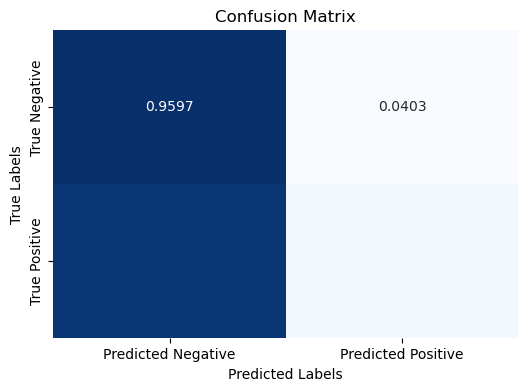

In [58]:
# Affichage des résultats
print(f"Test Loss: {test_loss:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-score: {average_f1:.4f}")
print("Confusion Matrix:")

# Affichage de la matrice de confusion après le calcul des métriques
plot_confusion_matrix(confusion_matrix_total,True)

# Save & Load

In [55]:
# Sauvegarder le modèle complet
torch.save(model, "model_full2.pth")
# Sauvegarder le modèle
torch.save(model.state_dict(), "model2.pth")

# Test

In [ ]:
import torch
from transformers import AutoTokenizer

# Charger le tokenizer et le modèle pré-entraîné
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
model2 = GLiNER(pretrained_model_name="microsoft/deberta-v3-base", num_entity_types=len(entity_to_id))
model2.load_state_dict(torch.load("model.pth"))  # Charger le modèle pré-entraîné
model2 = model2.to("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\doria\anaconda3\envs\vincentorch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\doria\anaconda3\envs\vincentorch\Lib\site-packages\transformers\convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [58]:
# Phrase d'exemple
sentence = "Paul is walking to University"
entity_types_to_detect = ["person", "organization"]

# Tokeniser la phrase
# Tokenize the entire text
encoded = tokenizer(sentence, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
input_id = encoded["input_ids"][0]
attention_mask = (encoded["attention_mask"][0])

current_entity_set = set()
for entity_type in entity_types_to_detect:
    if entity_type in entity_to_id:
        current_entity_set.add(entity_to_id[entity_type])
entity_tensor = torch.tensor(sorted(current_entity_set), dtype=torch.long)

In [59]:
# Effectuer la prédiction
model.eval()
with torch.no_grad():
    # Calcul des scores pour chaque token
    scores, _ = model(input_ids, attention_mask, spans=None, entity_ids=None)

# # Récupérer les entités prédites
# predicted_entities = []
# for token_idx, score in enumerate(scores[0]):
#     token = tokens[token_idx]
#     max_score_idx = score.argmax().item()  # Trouver l'indice de l'entité avec le score le plus élevé
#     entity_type = list(entity_to_id.keys())[max_score_idx - 1]  # Convertir l'indice en nom d'entité (ignorer l'entité "non-entité" qui est mappée à 0)
    
#     # Vérifier si l'entité est dans les types recherchés
#     if entity_type in entity_types_to_detect:
#         predicted_entities.append((token, entity_type))

# # Afficher les résultats
# print("Entities detected:")
# for token, entity_type in predicted_entities:
#     print(f"Token: {token}, Entity Type: {entity_type}")


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)